# Team Members
- Sam Ruben Abraham – 2023BCD0002
- Vinayak Sharma – 2023BCS0002
- Anush Bundel – 2023BCS0005
- Hafiz Feroze – 2023BCS0006

# Classical Solvers for Ising Hamiltonians

## Overview

This notebook implements two classical algorithms to solve the Ising Hamiltonian:

1. **Simulated Annealing (SA)**: A probabilistic optimization algorithm that mimics the process of annealing in metallurgy. It uses Metropolis acceptance criteria to escape local minima.

2. **Brute-Force Enumeration**: An exhaustive search over all possible bitstrings (up to N=16) to find the global minimum of the Hamiltonian.

### The Ising Hamiltonian

The Ising Hamiltonian is given by:

$$
H = \sum_i h_i z_i + \sum_{i<j} J_{ij} z_i z_j
$$

where:
- $z_i \in \{-1, 1\}$ are spin variables
- $h_i$ are linear bias terms
- $J_{ij}$ are pairwise coupling terms

The outputs include energy tracking plots and histograms of state energies for each method.

---
## Section 1: Setup and Dependencies

In [1]:
# Install required libraries
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# Set random seed for reproducibility
np.random.seed(42)

---
## Section 2: Define the Ising Energy Function

In [2]:
def ising_energy(z, h, J):
    """
    Calculate the Ising Hamiltonian energy for spin configuration z.

    Parameters:
    z : numpy.ndarray
        Array of +1/-1 spins (length N)
    h : numpy.ndarray
        Array of linear biases (length N)
    J : numpy.ndarray
        NxN symmetric coupling matrix (diagonal should be 0)

    Returns:
    float
        The energy of the configuration
    """
    # Linear term: sum of h_i * z_i
    linear_term = np.dot(h, z)

    # Interaction term: sum of J_ij * z_i * z_j
    # Divide by 2 to correct for double-counting in matrix multiplication
    interaction_term = 0.5 * np.dot(z, np.dot(J, z))

    # Total energy
    energy = linear_term + interaction_term

    return energy

print("Ising energy function defined.")

Ising energy function defined.


---
## Section 3: Define the Ising Problem


In [3]:

N = 8  # Number of spins

# Generate random linear biases
h = np.random.randn(N)

# Generate random coupling matrix
J = np.random.randn(N, N)

# Make J symmetric (required for Ising model)
J = 0.5 * (J + J.T)

# Set diagonal to zero (no self-interaction)
np.fill_diagonal(J, 0)

print(f"Ising problem defined with N = {N} spins")
print(f"\nLinear biases (h):\n{h}")
print(f"\nCoupling matrix (J):\n{J}")

Ising problem defined with N = 8 spins

Linear biases (h):
[ 0.49671415 -0.1382643   0.64768854  1.52302986 -0.23415337 -0.23413696
  1.57921282  0.76743473]

Coupling matrix (J):
[[ 0.         -0.23513554 -0.50390021 -0.23961349  0.49021443 -0.78483098
  -1.28206768  0.12511915]
 [-0.23513554  0.         -0.39855074 -1.23500732  0.81850853 -0.99440823
  -0.12084209 -0.03425408]
 [-0.50390021 -0.39855074  0.          0.59912147 -0.35814349  0.01619511
  -0.13522159  0.89013403]
 [-0.23961349 -1.23500732  0.59912147  0.         -0.04612005 -1.1723762
  -0.17632046  0.60019707]
 [ 0.49021443  0.81850853 -0.35814349 -0.04612005  0.         -0.6983831
  -0.4699065   0.70937913]
 [-0.78483098 -0.99440823  0.01619511 -1.1723762  -0.6983831   0.
   0.42267027  0.14308018]
 [-1.28206768 -0.12084209 -0.13522159 -0.17632046 -0.4699065   0.42267027
   0.         -0.41740551]
 [ 0.12511915 -0.03425408  0.89013403  0.60019707  0.70937913  0.14308018
  -0.41740551  0.        ]]


---
## Section 4: Simulated Annealing

### Algorithm Description

Simulated annealing is a stochastic metaheuristic for approximating the global minimum of a function. It mimics the physical process of cooling metal:

1. Start with a high "temperature" parameter that allows exploration
2. Gradually lower the temperature (cooling schedule)
3. At each step, propose a random spin flip
4. Accept or reject based on the Metropolis criterion:
   - Always accept if energy decreases
   - Accept with probability $\exp(-\Delta E / T)$ if energy increases

This allows occasional "uphill" moves to escape local minima early on, with fewer such moves as temperature decreases.

In [4]:
def simulated_annealing(h, J, num_iterations=1000, initial_temp=1.0):
    """
    Perform simulated annealing on the Ising Hamiltonian defined by (h, J).

    Parameters:
    h : numpy.ndarray
        Linear bias terms
    J : numpy.ndarray
        Coupling matrix
    num_iterations : int
        Number of SA iterations to perform
    initial_temp : float
        Starting temperature for the annealing schedule

    Returns:
    tuple
        (best_state, best_energy, energies, visited_energies)
        - best_state: The lowest energy configuration found
        - best_energy: Energy of the best state
        - energies: List of current energies at each iteration
        - visited_energies: List of all accepted state energies
    """
    N = len(h)

    # Initialize with a random spin configuration
    z = np.random.choice([-1, 1], size=N)
    current_energy = ising_energy(z, h, J)

    # Track the best solution found
    best_state = np.copy(z)
    best_energy = current_energy

    energies = [current_energy]
    visited_energies = [current_energy]

    for i in range(1, num_iterations + 1):
        # Linear cooling schedule
        T = initial_temp * (1 - i / num_iterations)

        # Prevent division by zero
        if T < 1e-12:
            T = 1e-12

        # Propose a move: flip one random spin
        j = np.random.randint(N)
        z_new = z.copy()
        z_new[j] = -z_new[j]  # Flip spin j

        # Calculate energy of proposed configuration
        new_energy = ising_energy(z_new, h, J)
        dE = new_energy - current_energy

        # Metropolis acceptance criterion
        if dE <= 0:
            accept = True
        else:
            accept = np.random.rand() < np.exp(-dE / T)

        if accept:
            z = z_new
            current_energy = new_energy

            if current_energy < best_energy:
                best_energy = current_energy
                best_state = z.copy()

        # Record current energy (whether accepted or not)
        energies.append(current_energy)
        visited_energies.append(current_energy)

    return best_state, best_energy, energies, visited_energies

### Run Simulated Annealing

In [5]:
# Run simulated annealing
best_state_sa, best_energy_sa, energies_sa, visited_sa = simulated_annealing(
    h, J,
    num_iterations=5000,
    initial_temp=2.0
)

# Display results
print(f"\n{'='*50}")
print("SIMULATED ANNEALING RESULTS")
print(f"{'='*50}")
print(f"Best energy found: {best_energy_sa:.4f}")
print(f"Best state (spins): {best_state_sa}")
print(f"Number of iterations: {len(energies_sa)}")


SIMULATED ANNEALING RESULTS
Best energy found: -11.3930
Best state (spins): [-1 -1 -1 -1 -1 -1 -1  1]
Number of iterations: 5001


### Visualize SA Results

We create two plots:
1. Energy vs. Iteration: Shows how the algorithm explores the energy landscape
2. Histogram of Visited Energies: Shows the distribution of energies sampled during the run

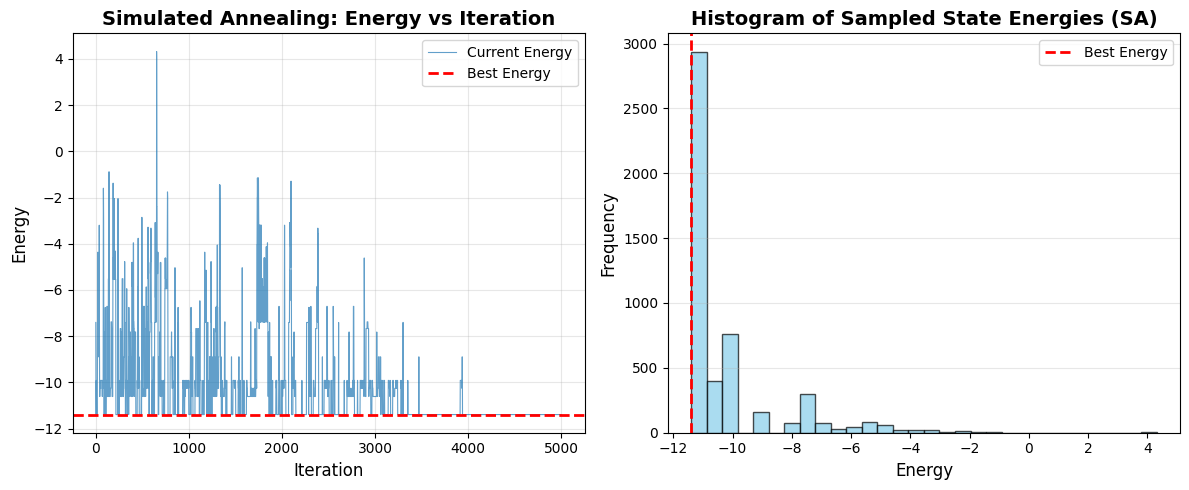

In [6]:
# Plot 1: Energy vs Iteration
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(energies_sa, linewidth=0.8, alpha=0.7, label='Current Energy')
plt.axhline(best_energy_sa, color='r', linestyle='--', linewidth=2, label='Best Energy')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Energy', fontsize=12)
plt.title('Simulated Annealing: Energy vs Iteration', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Plot 2: Histogram of Visited State Energies
plt.subplot(1, 2, 2)
plt.hist(visited_sa, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(best_energy_sa, color='r', linestyle='--', linewidth=2, label='Best Energy')
plt.xlabel('Energy', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of Sampled State Energies (SA)', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

---
## Section 5: Brute-Force Enumeration/N-choose-K Method

### Algorithm Description

As a contrast to heuristic methods, we implement a brute-force solver that:
1. Exhaustively checks every possible configuration of the N spins
2. Computes the energy for all $2^N$ spin assignments
3. Returns the state(s) with the minimum energy

**Note**: This approach is only feasible for small N (typically N ≤ 16) due to exponential scaling.

In [7]:
# Brute-force enumeration of all spin configurations
print("Running Brute-Force Enumeration...")
print(f"This will check all 2^{N} = {2**N} configurations.\n")

# Initialize tracking variables
energies_all = []
min_energy_bf = np.inf
min_states_bf = []

# Enumerate all 2^N configurations of ±1 spins
for config in product([-1, 1], repeat=N):
    z = np.array(config)
    E = ising_energy(z, h, J)
    energies_all.append(E)

    # Track minimum energy state(s)
    if E < min_energy_bf:
        min_energy_bf = E
        min_states_bf = [z.copy()]
    elif E == min_energy_bf:
        min_states_bf.append(z.copy())

# Display results
print(f"{'='*50}")
print("BRUTE-FORCE ENUMERATION RESULTS")
print(f"{'='*50}")
print(f"Minimum energy found: {min_energy_bf:.4f}")
print(f"Number of ground states: {len(min_states_bf)}")
print(f"\nGround state configuration(s):")
for idx, z in enumerate(min_states_bf, 1):
    print(f"  State {idx}: {z}")

Running Brute-Force Enumeration...
This will check all 2^8 = 256 configurations.

BRUTE-FORCE ENUMERATION RESULTS
Minimum energy found: -11.3930
Number of ground states: 1

Ground state configuration(s):
  State 1: [-1 -1 -1 -1 -1 -1 -1  1]


### Visualize Brute-Force Results

We plot the complete energy spectrum to see the distribution of all possible configuration energies.

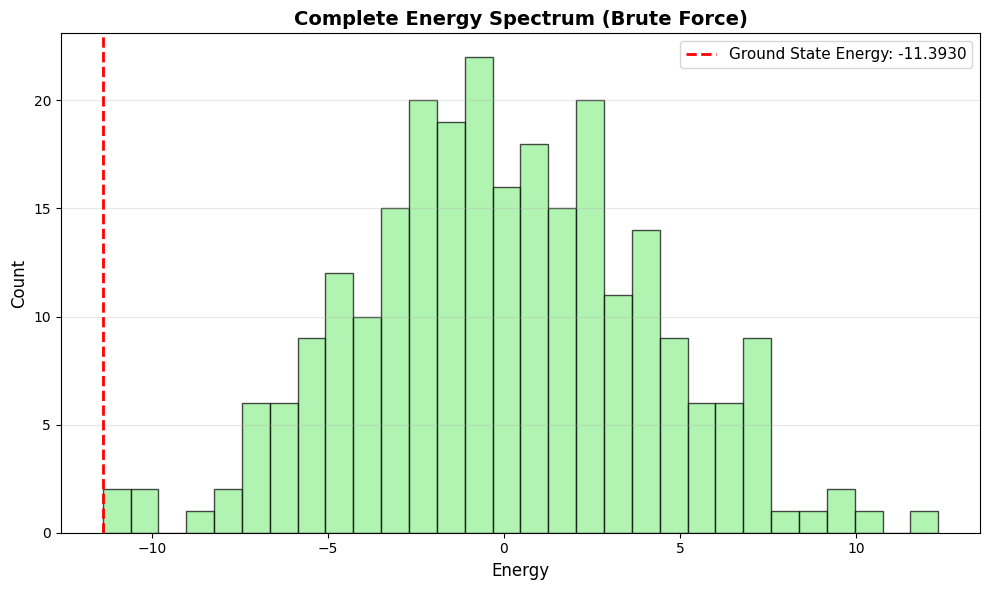


Energy Statistics:
  Minimum energy: -11.3930
  Maximum energy: 12.3341
  Mean energy: -0.0000
  Std deviation: 4.1339


In [8]:
# Plot histogram of energy distribution over all states
plt.figure(figsize=(10, 6))
plt.hist(energies_all, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
plt.axvline(min_energy_bf, color='r', linestyle='--', linewidth=2, label=f'Ground State Energy: {min_energy_bf:.4f}')
plt.xlabel('Energy', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Complete Energy Spectrum (Brute Force)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Print statistics
print(f"\nEnergy Statistics:")
print(f"  Minimum energy: {min(energies_all):.4f}")
print(f"  Maximum energy: {max(energies_all):.4f}")
print(f"  Mean energy: {np.mean(energies_all):.4f}")
print(f"  Std deviation: {np.std(energies_all):.4f}")

---
## Section 6: Comparison of Methods


In [9]:
# Comparison summary
print(f"{'='*70}")
print("COMPARISON OF METHODS")
print(f"{'='*70}")
print(f"\n{'Method':<30} {'Best Energy':<20} {'Status'}")
print(f"{'-'*70}")
print(f"{'Simulated Annealing':<30} {best_energy_sa:<20.4f} ", end="")

# Check if SA found the ground state
if abs(best_energy_sa - min_energy_bf) < 1e-6:
    print("✓ Found ground state")
else:
    energy_gap = best_energy_sa - min_energy_bf
    print(f"✗ Gap from ground state: {energy_gap:.4f}")

print(f"{'Brute Force':<30} {min_energy_bf:<20.4f} ✓ Ground state (exact)")
print(f"{'-'*70}")

# Computational comparison
print(f"\nComputational Complexity:")
print(f"  Simulated Annealing: O(iterations × N) = O(5000 × {N}) evaluations")
print(f"  Brute Force: O(2^N) = O(2^{N}) = {2**N} evaluations")
print(f"\n  For N={N}, brute force checked {2**N} states")
print(f"  while SA performed 5000 iterations.")

COMPARISON OF METHODS

Method                         Best Energy          Status
----------------------------------------------------------------------
Simulated Annealing            -11.3930             ✓ Found ground state
Brute Force                    -11.3930             ✓ Ground state (exact)
----------------------------------------------------------------------

Computational Complexity:
  Simulated Annealing: O(iterations × N) = O(5000 × 8) evaluations
  Brute Force: O(2^N) = O(2^8) = 256 evaluations

  For N=8, brute force checked 256 states
  while SA performed 5000 iterations.


### Visualize Both Methods Together


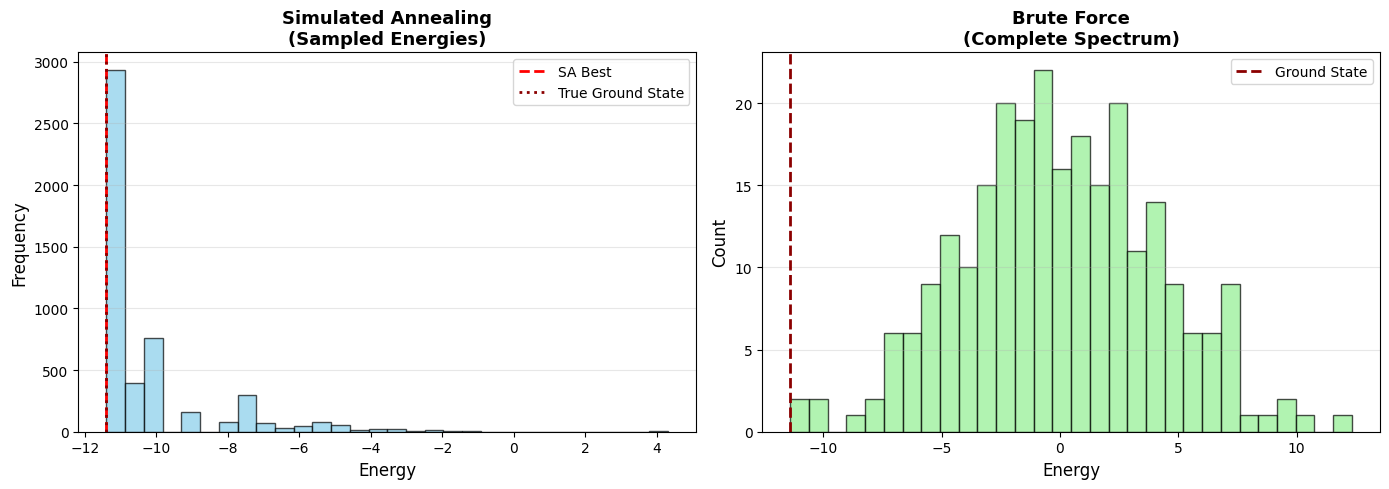

In [10]:
# Side-by-side comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SA energy distribution
axes[0].hist(visited_sa, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(best_energy_sa, color='r', linestyle='--', linewidth=2, label='SA Best')
axes[0].axvline(min_energy_bf, color='darkred', linestyle=':', linewidth=2, label='True Ground State')
axes[0].set_xlabel('Energy', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Simulated Annealing\n(Sampled Energies)', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3, axis='y')

# Brute force energy distribution
axes[1].hist(energies_all, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1].axvline(min_energy_bf, color='darkred', linestyle='--', linewidth=2, label='Ground State')
axes[1].set_xlabel('Energy', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Brute Force\n(Complete Spectrum)', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

---
## Section 7: Summary and Observations

#### 1. Simulated Annealing (SA)
**Advantages:**
- Efficient for large N (scales as O(iterations × N))
- Often finds near-optimal solutions quickly
- Uses stochastic Metropolis updates to escape local minima
- Practical for real-world problems

**Limitations:**
- No guarantee of finding the global optimum
- Performance depends on cooling schedule and iteration count
- May get stuck in local minima

#### 2. Brute-Force Enumeration
**Advantages:**
- Always finds the true ground state (exact solution)
- Provides complete energy spectrum
- No parameters to tune

**Limitations:**
- Exponential scaling: O(2^N) makes it infeasible for N > 16-20
- Computationally prohibitive for larger systems
